# NDIS v2.0 - Using Critical Path Method (CPM) and Random Forest

In [ ]:
from arcgis.gis import GIS
gis = GIS("home")

In [ ]:
%matplotlib inline
#ArcGIS packages
import arcpy
#from arcgis.mapping import WebScene
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from IPython.display import display
from arcgis.features import GeoAccessor
from arcgis import *
from arcpy.sa import Raster, Int  # Raster float to integer
# Raster processing for dataframe
from rasterstats import zonal_stats

# basic packages
import csv
import numpy as np
import os
import timeit
import random
import string
from playsound import playsound

# Data management
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point  # to get points from long lat

# Request service
#from requests import Request
import json
import re
from functools import reduce
#from owslib.wfs import WebFeatureService

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import export_text
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import warnings
import multiprocessing
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# To save the model and everything else to be API ready
import joblib
import pickle

In [ ]:
# Set the path to this geodatabase
gdb_path = r"D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb"  # This gdb path
arcpy.env.overwriteOutput = True

In [ ]:
# Import Database/Dataset
# Specify the feature class name
ghz_clean = "cleaned_geohazard_data"  # Geohazard feature class
ghz_clean_path = f"{gdb_path}\\{ghz_clean}"

# Use arcpy to create a list of fields
ghz_clean_fields = [f.name for f in arcpy.ListFields(f"{gdb_path}\\{ghz_clean}")]

# Use arcpy to create a search cursor and load the data into a list of dictionaries
ghz_clean_data = []
with arcpy.da.SearchCursor(f"{gdb_path}\\{ghz_clean}", ghz_clean_fields) as cursor:
    for row in cursor:
        ghz_clean_data.append(dict(zip(ghz_clean_fields, row)))

# Convert the list of dictionaries into a DataFrame
ghz_celan_df = pd.DataFrame(ghz_clean_data)
ghz_celan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   OBJECTID    int64  
 1   Shape       object 
 2   HazardID    float64
 3   latitude    float64
 4   longitude   float64
 5   HazardType  int64  
 6   distance    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 96.9+ MB


### Test Zonal Stats

In [ ]:
# Load feature class from the geodatabase using geopandas
layer_name = "buffer_30km"

# This loads the feature class as a GeoDataFrame
buffer_gdf = gpd.read_file(gdb_path, layer=layer_name)

# Raster path
population_raster = r"D:\NDIS_Database\12_Population_synthetic\nasapop20.tif"

# Run zonal stats (e.g., sum population within each buffer)
stats = zonal_stats(buffer_gdf, population_raster, stats=["sum"], geojson_out=True)

# Convert the result back to GeoDataFrame
result_gdf = gpd.GeoDataFrame.from_features(stats)

# Join result to original buffer if needed:
buffer_gdf["pop_sum"] = result_gdf["sum"]

#buffer_gdf.drop(columns="geometry").to_csv("buffer_pop.csv", index=False)

### Buffering, Zonal Stats

In [ ]:
# Parameters
# Name of feature class inside the gdb
layer_name = "cleaned_geohazard_data"
# Use geopandas to read it
input_gdf = gpd.read_file(gdb_path, layer=layer_name)
population_raster = r"D:\NDIS_Database\12_Population_synthetic\nasapopct.tif"
buffer_dist = 30000  # 30km
chunk_size = 10000
std_threshold = 10

# Load input as GeoDataFrame
#gdf = gpd.read_file(input_fc)

# Reproject to WGS84 (EPSG:4326) if needed
if input_gdf.crs.to_epsg() != 4326:
    input_gdf = input_gdf.to_crs(epsg=4326)

# Calculate approximate buffer distance in degrees
buffer_deg = buffer_dist / 111320.0  # 1 degree ≈ 111.32 km at equator

# Final results
final_chunks = []

total = len(input_gdf)
print(f"🔹 Total features: {total}")

for start in range(0, total, chunk_size):
    print(f"🔹 Processing chunk {start+1} to {min(start + chunk_size, total)}")

    chunk = input_gdf.iloc[start:start + chunk_size].copy()

    # Suppress geographic CRS buffer warning
    warnings.filterwarnings("ignore", message="Geometry is in a geographic CRS.*")
    chunk["geometry"] = chunk.geometry.buffer(buffer_deg)

    # Zonal statistics
    stats = zonal_stats(chunk, population_raster,
                        stats=["mean", "majority", "count", "std"],
                        geojson_out=False)

    # Smart pop estimation
    smart_pops = []
    for row in stats:
        count = row.get("count", 0) or 0
        mean = row.get("mean", 0) or 0
        majority = row.get("majority", 0) or 0
        std = row.get("std", 0) or 0

        if count == 0:
            pop = 0
        elif std < std_threshold:
            pop = majority * count
        else:
            pop = mean * count

        smart_pops.append(pop)

    chunk["pop"] = smart_pops
    final_chunks.append(chunk)

    print(f"✅ Chunk {start+1} processed.")

# Combine all results
final_gdf = pd.concat(final_chunks, ignore_index=True)

# Optional: export to CSV
# final_gdf.drop(columns="geometry").to_csv("smart_population_estimate.csv", index=False)

print("🎉 All done. Result in dataframe: final_gdf.")

🔹 Total features: 1814699
🔹 Processing chunk 1 to 10000
✅ Chunk 1 processed.
🔹 Processing chunk 10001 to 20000
✅ Chunk 10001 processed.
🔹 Processing chunk 20001 to 30000
✅ Chunk 20001 processed.
🔹 Processing chunk 30001 to 40000
✅ Chunk 30001 processed.
🔹 Processing chunk 40001 to 50000
✅ Chunk 40001 processed.
🔹 Processing chunk 50001 to 60000
✅ Chunk 50001 processed.
🔹 Processing chunk 60001 to 70000
✅ Chunk 60001 processed.
🔹 Processing chunk 70001 to 80000
✅ Chunk 70001 processed.
🔹 Processing chunk 80001 to 90000
✅ Chunk 80001 processed.
🔹 Processing chunk 90001 to 100000
✅ Chunk 90001 processed.
🔹 Processing chunk 100001 to 110000
✅ Chunk 100001 processed.
🔹 Processing chunk 110001 to 120000
✅ Chunk 110001 processed.
🔹 Processing chunk 120001 to 130000
✅ Chunk 120001 processed.
🔹 Processing chunk 130001 to 140000
✅ Chunk 130001 processed.
🔹 Processing chunk 140001 to 150000
✅ Chunk 140001 processed.
🔹 Processing chunk 150001 to 160000
✅ Chunk 150001 processed.
🔹 Processing chunk 

In [ ]:
counts = final_gdf.groupby('HazardType').size()
count_volc = counts.get(1, 0)
print("Occurrences of 'volc':", count_volc)

Occurrences of 'volc': 1044


In [ ]:
final_gdf["pop"] = final_gdf["pop"].fillna(0)
final_gdf.to_csv(r"D:\NDIS_Database\12_Population_synthetic\ghz_pop.csv", index=False)

In [ ]:
final_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 7 columns):
 #   Column      Dtype   
---  ------      -----   
 0   HazardID    float64 
 1   latitude    float64 
 2   longitude   float64 
 3   HazardType  int64   
 4   distance    float64 
 5   geometry    geometry
 6   pop         float64 
dtypes: float64(5), geometry(1), int64(1)
memory usage: 96.9 MB


## Preprocess Volcano

In [ ]:
# Load
# Use known item ID
item_id1 = "0db01e3f54934c0c8060f5acdf326d01"
volc1 = gis.content.get(item_id1)

# Inspect the item
print(f"Title: {volc1.title}")
print(f"Type: {volc1.type}")

# Access the first layer in the feature service
v1_layer = volc1.layers[0]

# Load it into a Spatially Enabled DataFrame (SeDF)
volc1_sdf = v1_layer.query(where="1=1").sdf
volc1_sdf.info()

Title: Volcanic eruptions from 1950 to 2022
Type: Feature Service
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   FID         2456 non-null   Int64         
 1   Volcano_Nu  2456 non-null   Float64       
 2   Volcano_Na  2456 non-null   string        
 3   Eruption_N  2456 non-null   Float64       
 4   Eruption_C  2456 non-null   string        
 5   Area_of_Ac  2456 non-null   string        
 6   VEI         2456 non-null   string        
 7   VEI_Modifi  2456 non-null   string        
 8   Start_Year  2456 non-null   string        
 9   Date        2456 non-null   string        
 10  Start_Ye_1  2456 non-null   string        
 11  Start_Ye_2  2456 non-null   string        
 12  Start_Mont  2456 non-null   string        
 13  Start_Day   2456 non-null   string        
 14  Start_Da_1  2456 non-null   string        
 15  Start_

In [ ]:
# Load
# Use known item ID
item_id2 = "e991eccebfa5425e9180d884af76f16a"  # Item ID
volc2 = gis.content.get(item_id2)

# Inspect the item
print(f"Title: {volc2.title}")
print(f"Type: {volc2.type}")

# Access the first layer in the feature service
v2_layer = volc2.layers[0]

# Load it into a Spatially Enabled DataFrame (SeDF)
volc2_sdf = v2_layer.query(where="1=1").sdf
volc2_sdf.info()

Title: Significant Volcanic Events
Type: Feature Service
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   YEAR                           889 non-null    Int32   
 1   MO                             757 non-null    Int32   
 2   DAY                            698 non-null    Int32   
 3   VEI                            711 non-null    Int32   
 4   VOL_ID                         889 non-null    Float64 
 5   FATALITIES                     448 non-null    Int32   
 6   ASSOC_EQ                       79 non-null     string  
 7   ASSOC_TSU                      177 non-null    string  
 8   COMMENTS                       873 non-null    string  
 9   DAMAGE_MILLIONS_DOLLARS        25 non-null     Float64 
 10  DAMAGE_AMOUNT_ORDER            249 non-null    Int32   
 11  DAMAGE_DESCRIPTION             249 non-n

In [ ]:
volc2_sdf.DAMAGE_TOTAL_DESCRIPTION.unique()

<StringArray>
['Extreme (~$25 million or more)',                             <NA>,
   'Severe (~>$5 to $24 million)',          'Limited (<$1 million)',
   'Moderate (~$1 to $5 million)']
Length: 5, dtype: string

In [ ]:
volcano_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HazardID    1044 non-null   Int64  
 1   latitude    1044 non-null   float64
 2   longitude   1044 non-null   float64
 3   HazardType  1044 non-null   int64  
 4   distance    1044 non-null   float64
 5   pop         1044 non-null   float64
 6   vei         1044 non-null   Int32  
dtypes: Int32(1), Int64(1), float64(4), int64(1)
memory usage: 55.2 KB


In [ ]:
# Load datasets
main_db = final_gdf      # main geohazard database
data1 = volc1_sdf          # External source 1
data2 = volc2_sdf          # External source 2

# Filter volcanoes
volcano_db = main_db[main_db["HazardType"] == 1].copy()

# Clean data
volcano_db["HazardID"] = volcano_db["HazardID"].astype("Int64")
data2["ID"] = data2["ID"].astype("Int64")
data1["Volcano_Nu"] = data1["Volcano_Nu"].astype("Int64")
# Clean VEI in both datasets to be proper floats
data1["VEI"] = pd.to_numeric(data1["VEI"], errors="coerce")
data2["VEI"] = pd.to_numeric(data2["VEI"], errors="coerce")
data2["DEATHS_TOTAL"] = pd.to_numeric(data2["DEATHS_TOTAL"], errors="coerce")


# Match by ID: main_db.HazardID ↔ data2.ID
merge_d2 = pd.merge(volcano_db, data2[["ID", "VEI", "DEATHS_TOTAL"]],
                    left_on="HazardID", right_on="ID", how="left")

# Match by ID: main_db.HazardID ↔ data1.Volcano_Nu
merge_d1 = pd.merge(volcano_db, data1[["Volcano_Nu", "VEI"]],
                    left_on="HazardID", right_on="Volcano_Nu", how="left", suffixes=('', '_d1'))

# Combine VEIs: prefer data2 over data1
vei_combined = merge_d2.copy()
vei_combined["VEI_d1"] = merge_d1["VEI"]
vei_combined["VEI"] = vei_combined["VEI"].fillna(vei_combined["VEI_d1"])

# Estimate VEI from deaths
def estimate_vei_from_deaths(deaths):
    if pd.isna(deaths):
        return np.nan
    return min(8, int(deaths / 1000) + 2)

missing_vei = vei_combined["VEI"].isna()
vei_combined.loc[missing_vei, "VEI"] = vei_combined.loc[missing_vei, "DEATHS_TOTAL"].apply(estimate_vei_from_deaths)

# STEP 3: Weighted random VEI (realistic distribution)
missing_vei = vei_combined["VEI"].isna()
vei_probs = [0.05, 0.1, 0.2, 0.3, 0.2, 0.1, 0.03, 0.015, 0.005]  # VEI 0–8
vei_values = list(range(9))
vei_combined.loc[missing_vei, "VEI"] = np.random.choice(vei_values, size=missing_vei.sum(), p=vei_probs)

# Option 2: completely random VEI:
# Assign random VEI for any remaining
#missing_vei = vei_combined["VEI"].isna()
#vei_combined.loc[missing_vei, "VEI"] = [random.randint(1, 5) for _ in range(missing_vei.sum())]

# Final cleanup
vei_combined = vei_combined.rename(columns={"VEI": "vei"})
volcano_df = vei_combined[["HazardID", "latitude", "longitude", "HazardType", "distance", "pop","vei"]].copy()
volcano_df["vei"] = pd.to_numeric(volcano_df["vei"], errors="coerce")
volcano_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HazardID    1044 non-null   Int64  
 1   latitude    1044 non-null   float64
 2   longitude   1044 non-null   float64
 3   HazardType  1044 non-null   int64  
 4   distance    1044 non-null   float64
 5   pop         1044 non-null   float64
 6   vei         1044 non-null   Int32  
dtypes: Int32(1), Int64(1), float64(4), int64(1)
memory usage: 55.2 KB


### Convert VEI to intensity

In [ ]:
volcano_sc = volcano_df.copy()

In [ ]:
volcano_sc["vei"] = volcano_sc["vei"].astype("int64")
vei = volcano_sc["vei"].values  # pull as NumPy array

conditions = [
    vei <= 1,
    vei == 2,
    np.isin(vei, [3, 4]),
    np.isin(vei, [5, 6]),
    vei >= 7
]

choices = [1, 2, 3, 4, 5]


volcano_sc["intensity"] = np.select(conditions, choices, default=3)  # Default to 3 if VEI is missing
volcano_sc

,HazardID,latitude,longitude,HazardType,distance,pop,vei,intensity
0,210010,50.170,6.85,1,34.462092,1.346558e+05,2,2
1,210020,45.775,2.97,1,1068.063073,4.145101e+05,3,3
2,210030,42.170,2.53,1,1798.388196,1.461354e+05,0,1
3,210040,38.870,-4.02,1,547.012635,1.739199e+05,2,2
4,211004,41.730,12.70,1,183.805721,2.411999e+06,1,1
...,...,...,...,...,...,...,...,...
1039,384010,14.950,-24.35,1,4486.383341,3.819591e+04,1,1
1040,384020,14.850,-24.72,1,104.898079,6.569345e+03,2,2
1041,385050,-7.950,-14.37,1,323.701364,8.805010e+02,2,2
1042,386010,-37.092,-12.28,1,3066.129641,3.215129e+02,3,3


### Get Duration for CPM

In [ ]:
# Step 1: Match `data1` rows to volcano_df based on HazardID
volc_dur = pd.merge(
    volcano_sc[["HazardID", "vei"]],
    data1,
    left_on="HazardID", right_on="Volcano_Nu",
    how="left"
)

# Step 2: Parse duration from Start/End fields

def safe_date(year, month, day):
    try:
        if pd.isna(year) or year == "":
            return None
        year = int(float(year))
        month = int(float(month)) if month else 1
        day = int(float(day)) if day else 1
        return datetime(year, month, day)
    except:
        return None

def calculate_duration_minutes(row):
    start = safe_date(row["Start_Year"], row["Start_Mont"], row["Start_Day"])
    end = safe_date(row["End_Year"], row["End_Month"], row["End_Day"])
    if start and end and end >= start:
        return round((end - start).total_seconds() / 60)
    else:
        return None

volc_dur["duration_minutes"] = volc_dur.apply(calculate_duration_minutes, axis=1)

# Step 3: Generate random duration based on vei_assigned
def generate_duration_from_vei(vei):
    if pd.isna(vei):
        return None
    vei = int(vei)
    duration_ranges = {
        0: (10, 60),
        1: (60, 360),
        2: (1440, 2880),
        3: (2880, 10080),
        4: (7200, 43200),
        5: (43200, 129600),
        6: (129600, 525600),
        7: (525600, 2628000),
        8: (525600, 2628000),
    }
    if vei in duration_ranges:
        return random.randint(*duration_ranges[vei])
    else:
        return random.randint(60, 10000)

# Fill missing durations
volc_dur["duration_minutes"] = volc_dur["duration_minutes"].fillna(
    volc_dur["vei"].apply(generate_duration_from_vei)
)

dur_stats = volc_dur.groupby("HazardID")["duration_minutes"].agg(["min", "max", "mean", "count"]).reset_index()
dur_stats.columns = ["HazardID", "min_duration", "max_duration", "avg_duration", "eruption_count"]

# Step 4: Merge back into volcano_df
volcano_sc = volcano_sc.merge(dur_stats, on="HazardID", how="left")

volcano_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HazardID        1044 non-null   Int64  
 1   latitude        1044 non-null   float64
 2   longitude       1044 non-null   float64
 3   HazardType      1044 non-null   int64  
 4   distance        1044 non-null   float64
 5   pop             1044 non-null   float64
 6   vei             1044 non-null   int64  
 7   intensity       1044 non-null   int32  
 8   min_duration    1044 non-null   int64  
 9   max_duration    1044 non-null   int64  
 10  avg_duration    1044 non-null   float64
 11  eruption_count  1044 non-null   int64  
dtypes: Int64(1), float64(5), int32(1), int64(5)
memory usage: 94.9 KB


In [ ]:
volcano_sc.to_csv(r"D:\NDIS_Database\01_Volcano\volc_rf.csv", index=False)

In [ ]:
volcano_sc.eruption_count.unique()

array([ 1, 20,  2, 12, 29,  5,  6, 10, 58, 24,  4, 40,  3, 21, 36,  9, 32,
       17, 33, 19,  7, 26, 30, 11, 16, 15,  8, 23, 31, 14, 18, 13, 42, 52,
       48, 22, 27], dtype=int64)

### Economic loss

In [ ]:
# Map the string info
desc_map = {
    "Limited (<$1 million)": 0.5,
    "Moderate (~$1 to $5 million)": 3,
    "Severe (~>$5 to $24 million)": 15,
    "Extreme (~$25 million or more)": 50
}

data2["damage_desc_est"] = data2["DAMAGE_TOTAL_DESCRIPTION"].map(desc_map)

In [ ]:
# Start with actual values
data2["econ_loss_million"] = data2["DAMAGE_MILLIONS_DOLLARS_TOTAL"]

# Fill from description-based estimate
data2["econ_loss_million"] = data2["econ_loss_million"].fillna(data2["damage_desc_est"])

# Fill remaining missing with random or intensity-based simulation
def simulate_econ_loss(intensity):
    base = {
        1: (0.1, 1),
        2: (1, 5),
        3: (5, 20),
        4: (20, 100),
        5: (100, 500)
    }
    return round(random.uniform(*base.get(int(intensity), (1, 10))), 2)

# Merge with volcano_df
volcano_sc = volcano_sc.merge(
    data2[["ID", "DAMAGE_MILLIONS_DOLLARS_TOTAL", "DAMAGE_TOTAL_DESCRIPTION", "econ_loss_million"]],
    left_on="HazardID", right_on="ID", how="left"
)

# Fill any remaining NA values
volcano_sc["econ_loss_million"] = volcano_sc.apply(
    lambda r: simulate_econ_loss(r["intensity"]) if pd.isna(r["econ_loss_million"]) else r["econ_loss_million"],
    axis=1
)

In [ ]:
volcano_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   HazardID                       1044 non-null   Int64  
 1   latitude                       1044 non-null   float64
 2   longitude                      1044 non-null   float64
 3   HazardType                     1044 non-null   int64  
 4   distance                       1044 non-null   float64
 5   pop                            1044 non-null   float64
 6   vei                            1044 non-null   int64  
 7   intensity                      1044 non-null   int32  
 8   min_duration                   1044 non-null   int64  
 9   max_duration                   1044 non-null   int64  
 10  avg_duration                   1044 non-null   float64
 11  eruption_count                 1044 non-null   int64  
 12  ID                             0 non-null      I

In [ ]:
# Drop columns 12-14
volcano_sc = volcano_sc.drop(['ID', 'DAMAGE_MILLIONS_DOLLARS_TOTAL', 'DAMAGE_TOTAL_DESCRIPTION'], axis=1)
volcano_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HazardID           1044 non-null   Int64  
 1   latitude           1044 non-null   float64
 2   longitude          1044 non-null   float64
 3   HazardType         1044 non-null   int64  
 4   distance           1044 non-null   float64
 5   pop                1044 non-null   float64
 6   vei                1044 non-null   int64  
 7   intensity          1044 non-null   int32  
 8   min_duration       1044 non-null   int64  
 9   max_duration       1044 non-null   int64  
 10  avg_duration       1044 non-null   float64
 11  eruption_count     1044 non-null   int64  
 12  econ_loss_million  1044 non-null   float64
dtypes: Int64(1), float64(6), int32(1), int64(5)
memory usage: 103.1 KB


In [ ]:
volcano_sc.to_csv(r"D:\NDIS_Database\01_Volcano\volc_rf.csv", index=False)

## Preprocess Landslide

In [ ]:
# Read the shapefile from local disk
landslide_df = gpd.read_file(r"D:/NDIS_Database/04_Landslide/nasa_coolr_reports_point.shp")
landslide_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   src_name    14718 non-null  object  
 1   src_link    13879 non-null  object  
 2   ev_date     13087 non-null  object  
 3   ev_time     6555 non-null   object  
 4   ev_title    14026 non-null  object  
 5   ev_desc     12176 non-null  object  
 6   loc_desc    13195 non-null  object  
 7   loc_acc     14693 non-null  object  
 8   ls_cat      14720 non-null  object  
 9   ls_trig     14720 non-null  object  
 10  ls_size     14719 non-null  object  
 11  ls_setting  14713 non-null  object  
 12  fatalities  14723 non-null  int64   
 13  injuries    14723 non-null  int64   
 14  storm_name  666 non-null    object  
 15  photo_link  2228 non-null   object  
 16  comments    2560 non-null   object  
 17  ev_imp_src  14723 non-null  object  
 18  ev_imp_id   11689 non-null  object  
 

In [ ]:
landslide_df.ls_size.unique()

array(['unknown', 'medium', 'small', 'large', 'very_large',
       'catastrophic', 'Unknown', 'Large', None], dtype=object)

In [ ]:
ls_size_map = {
    'small': 1,
    'medium': 2,
    'large': 3,
    'very_large': 4,
    'catastrophic': 5,
    'unknown': np.nan,
    'Unknown': np.nan,
    None: np.nan
}

In [ ]:
# Map the size/severity
landslide_df["ls_size_norm"] = landslide_df["ls_size"].str.lower().map(ls_size_map)

In [ ]:
# Clean them first
landslide_df["fatalities"] = pd.to_numeric(landslide_df["fatalities"], errors="coerce").fillna(0)
landslide_df["injuries"] = pd.to_numeric(landslide_df["injuries"], errors="coerce").fillna(0)

In [ ]:
landslide_df["casualty_score"] = landslide_df["fatalities"] + 0.5 * landslide_df["injuries"]

# Normalize casualty score (so it's 0–5 range)
casualty_scaled = MinMaxScaler().fit_transform(landslide_df[["casualty_score"]])
landslide_df["casualty_scaled"] = casualty_scaled * 5

# Final intensity: weighted combo
landslide_df["intensity"] = (
    landslide_df["ls_size_norm"].fillna(0) * 0.7 +
    landslide_df["casualty_scaled"].fillna(0) * 0.3
).round()

# For simpler version, use landslide size directly without accommodating fatalities
#landslide_df["intensity"] = landslide_df["ls_size_norm"]
landslide_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Data columns (total 34 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   src_name         14718 non-null  object  
 1   src_link         13879 non-null  object  
 2   ev_date          13087 non-null  object  
 3   ev_time          6555 non-null   object  
 4   ev_title         14026 non-null  object  
 5   ev_desc          12176 non-null  object  
 6   loc_desc         13195 non-null  object  
 7   loc_acc          14693 non-null  object  
 8   ls_cat           14720 non-null  object  
 9   ls_trig          14720 non-null  object  
 10  ls_size          14719 non-null  object  
 11  ls_setting       14713 non-null  object  
 12  fatalities       14723 non-null  int64   
 13  injuries         14723 non-null  int64   
 14  storm_name       666 non-null    object  
 15  photo_link       2228 non-null   object  
 16  comments         2560 non-null  

In [ ]:
def estimate_landslide_duration(size):
    if pd.isna(size):
        return random.randint(30, 180)  # fallback: 30 min – 3 hrs
    duration_ranges = {
        1: (10, 60),
        2: (30, 90),
        3: (60, 120),
        4: (180, 360),
        5: (360, 1440)
    }
    return random.randint(*duration_ranges.get(int(size), (30, 180)))

landslide_df["duration_minutes"] = landslide_df["ls_size_norm"].apply(estimate_landslide_duration)

In [ ]:
len(main_db[main_db["HazardType"] == 2].copy())

14064

In [ ]:
dupes = landslide_df["HazardID"].value_counts()
print(dupes[dupes > 1])

HazardID
0    17
Name: count, dtype: int64


In [ ]:
# Keep only one row per HazardID (e.g., first)
landslide_df_dedup = landslide_df.drop_duplicates(subset="HazardID", keep="first")

# Merge data to main landslide in database
# 1. Ensure keys match (rename 'ev_id' to 'HazardID' if needed)
landslide_df = landslide_df.rename(columns={"ev_id": "HazardID"})

# 2. Select only the fields to bring over
fields_to_merge = ["HazardID", "ls_size", "fatalities", "injuries", "intensity", "duration_minutes"]

# # 3. Merge into filtered main_db landslide records
landslide_db = main_db[main_db["HazardType"] == 2].copy()

# 4. Merge attributes
landslide_db = landslide_db.merge(
    landslide_df_dedup[fields_to_merge],
    on="HazardID",
    how="left"
)
landslide_db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14064 entries, 0 to 14063
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   HazardID          14064 non-null  int64   
 1   latitude          14064 non-null  float64 
 2   longitude         14064 non-null  float64 
 3   HazardType        14064 non-null  int64   
 4   distance          14064 non-null  float64 
 5   geometry          14064 non-null  geometry
 6   pop               14064 non-null  float64 
 7   ls_size           14061 non-null  object  
 8   fatalities        14064 non-null  int64   
 9   injuries          14064 non-null  int64   
 10  intensity         14064 non-null  float64 
 11  duration_minutes  14064 non-null  int64   
dtypes: float64(5), geometry(1), int64(5), object(1)
memory usage: 1.3+ MB


### Economic loss

In [ ]:
def simulate_landslide_econ_loss(intensity, pop, fatalities=0, injuries=0):
    # Base economic ranges per intensity (in millions USD)
    base_ranges = {
        1: (0.1, 1),
        2: (1, 5),
        3: (5, 20),
        4: (20, 100),
        5: (100, 300)
    }

    # Get the base economic loss range
    low, high = base_ranges.get(int(intensity), (1, 10))

    # Normalize population (avoid zero division)
    pop_factor = (pop / 1e6) if pop and pop > 0 else 1

    # Casualty impact (additive boost)
    casualty_boost = (fatalities + 0.5 * injuries) * 0.05  # tweak this multiplier as needed

    # Final simulated economic loss (in millions USD)
    econ_loss = random.uniform(low, high) * pop_factor + casualty_boost
    return round(econ_loss, 2)

In [ ]:
landslide_db["economic_loss_million"] = landslide_db.apply(
    lambda r: simulate_landslide_econ_loss(
        r["intensity"],
        r["pop"],
        r.get("fatalities", 0),
        r.get("injuries", 0)
    ),
    axis=1
)

In [ ]:
landslide_db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14064 entries, 0 to 14063
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   HazardID               14064 non-null  int64   
 1   latitude               14064 non-null  float64 
 2   longitude              14064 non-null  float64 
 3   HazardType             14064 non-null  int64   
 4   distance               14064 non-null  float64 
 5   geometry               14064 non-null  geometry
 6   pop                    14064 non-null  float64 
 7   ls_size                14061 non-null  object  
 8   fatalities             14064 non-null  int64   
 9   injuries               14064 non-null  int64   
 10  intensity              14064 non-null  float64 
 11  duration_minutes       14064 non-null  int64   
 12  economic_loss_million  14064 non-null  float64 
dtypes: float64(6), geometry(1), int64(5), object(1)
memory usage: 1.4+ MB


In [ ]:
landslide_db.to_csv(r"D:\NDIS_Database\04_Landslide\landslide_rf.csv", index=False)

## Tsunami

In [ ]:
# Load
# Use known item ID
item_id3 = "5a44c3d4d465498993120b70ab568876"  # Item ID
tsun = gis.content.get(item_id3)

# Inspect the item
print(f"Title: {tsun.title}")
print(f"Type: {tsun.type}")

# Access the first layer in the feature service
tsun_layer = tsun.layers[0]

# Load it into a Spatially Enabled DataFrame (SeDF)
tsun_sdf = tsun_layer.query(where="1=1").sdf
tsun_sdf.info()

Title: Historical Tsunami Events
Type: Feature Service
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625 entries, 0 to 2624
Data columns (total 76 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   UNIQUE_ID                      2625 non-null   Int64         
 1   YEAR                           2625 non-null   Int32         
 2   MONTH                          2514 non-null   Int32         
 3   DAY                            2430 non-null   Int32         
 4   HOUR                           1554 non-null   Int32         
 5   MINUTE                         1471 non-null   Int32         
 6   SECOND                         1047 non-null   Float64       
 7   DATE_STRING                    2625 non-null   string        
 8   EVENT_DATE                     2596 non-null   datetime64[us]
 9   LATITUDE                       2625 non-null   Float64       
 10  LONGITUDE                    

In [ ]:
tsun_sdf.TS_MT_II.unique()

<FloatingArray>
[ <NA>,   1.0,   2.0,   1.6,   1.5,   4.0,   3.0,   3.3,   2.5,   0.0,   2.6,
   4.6,   3.5,   5.6,   4.5,   3.2,   1.8,   3.6,   0.8,   1.3,   0.3,  -0.1,
   6.4,   2.2,   0.5,   2.3,   3.9,   4.2,  -1.0,   4.3,   1.1,  -0.7,   4.4,
  -0.5,   5.9,   5.1,   3.4,   5.2,  -1.7,  -2.3,  -3.3,   0.6,  -1.3,   1.7,
   2.8,  -2.0,   4.9,   0.4,  -0.3,   3.7,   0.1,   0.9,   2.9,   2.7,  -1.5,
   5.0,   1.4,   6.1, -2.18,   4.7,   1.2, -4.64,  0.58,  2.32,   8.4]
Length: 65, dtype: Float64

In [ ]:
tsun_sdf.TS_INTENSITY.unique()

<FloatingArray>
[  6.0,   5.0,   3.0,  <NA>,   4.0,   1.0,   3.5,   2.0,   1.5,   2.5,   0.0,
   0.5,  -0.5,  -1.5,  -1.0,  -3.0,  -2.5,   3.8,  -2.0,  -4.0,   9.0,  -3.5,
   0.2,   2.8,   2.7,   3.1,   2.6,   2.1,   1.8,   1.9, -4.14,  1.08,  2.82]
Length: 33, dtype: Float64

In [ ]:
# Map the intensity from IIDA intensity
def map_tsunami_intensity(ts_mt_ii):
    if pd.isna(ts_mt_ii):
        return np.nan
    elif ts_mt_ii < 1:
        return 1
    elif ts_mt_ii < 3:
        return 2
    elif ts_mt_ii < 4.5:
        return 3
    elif ts_mt_ii < 6:
        return 4
    else:
        return 5

tsun_sdf["intensity"] = tsun_sdf["TS_MT_II"].apply(map_tsunami_intensity)

In [ ]:
def fallback_from_runup(runup):
    if pd.isna(runup):
        return np.nan
    elif runup < 1:
        return 1
    elif runup < 3:
        return 2
    elif runup < 6:
        return 3
    elif runup < 10:
        return 4
    else:
        return 5

tsun_sdf.loc[tsun_sdf["intensity"].isna(), "intensity"] = tsun_sdf.loc[
    tsun_sdf["intensity"].isna(), "MAX_EVENT_RUNUP"].apply(fallback_from_runup)

In [ ]:
tsun_intensity_probs = [0.05, 0.15, 0.4, 0.25, 0.15]
tsun_intensity_vals = [1, 2, 3, 4, 5]

missing_mask = tsun_sdf["intensity"].isna()
tsun_sdf.loc[missing_mask, "intensity"] = np.random.choice(
    tsun_intensity_vals,
    size=missing_mask.sum(),
    p=tsun_intensity_probs
)

In [ ]:
def estimate_tsunami_duration(intensity):
    if pd.isna(intensity):
        return random.randint(60, 240)  # fallback 1–4 hours
    ranges = {
        1: (15, 30),
        2: (30, 90),
        3: (90, 180),
        4: (180, 360),
        5: (360, 720),
    }
    return random.randint(*ranges[intensity])

tsun_sdf["duration_minutes"] = tsun_sdf["intensity"].apply(estimate_tsunami_duration)

In [ ]:
# Description fallback map
desc_map = {
    "Limited (<$1 million)": 0.5,
    "Moderate (~$1 to $5 million)": 3,
    "Severe (~>$5 to $24 million)": 15,
    "Extreme (~$25 million or more)": 50
}

tsun_sdf["damage_desc_est"] = tsun_sdf["DAMAGE_TOTAL_DESCRIPTION"].map(desc_map)

# Primary economic value
tsun_sdf["economic_loss_million"] = tsun_sdf["DAMAGE_MILLIONS_DOLLARS_TOTAL"]
tsun_sdf["economic_loss_million"] = tsun_sdf["economic_loss_million"].fillna(tsun_sdf["damage_desc_est"])

In [ ]:
def simulate_tsun_econ_loss(intensity, pop, fatalities=0, injuries=0):
    base_ranges = {
        1: (1, 5),
        2: (5, 20),
        3: (20, 100),
        4: (100, 500),
        5: (500, 2000)
    }

    # Fallbacks for missing inputs
    if pd.isna(intensity):
        intensity = 3
    if pd.isna(pop) or pop <= 0:
        pop = 1e6  # assume 1 million as fallback
    if pd.isna(fatalities):
        fatalities = 0
    if pd.isna(injuries):
        injuries = 0

    low, high = base_ranges.get(int(intensity), (10, 100))
    pop_factor = pop / 1e6
    casualty_boost = (fatalities + 0.5 * injuries) * 0.1

    return round(random.uniform(low, high) * pop_factor + casualty_boost, 2)

In [ ]:
## Get into filtered main_db tsunami records
tsunami_db = main_db[main_db["HazardType"] == 3].copy()
tsunami_db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 369 entries, 4 to 5932
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   HazardID    369 non-null    int64   
 1   latitude    369 non-null    float64 
 2   longitude   369 non-null    float64 
 3   HazardType  369 non-null    int64   
 4   distance    369 non-null    float64 
 5   geometry    369 non-null    geometry
 6   pop         369 non-null    float64 
dtypes: float64(4), geometry(1), int64(2)
memory usage: 23.1 KB


In [ ]:
tsun_sdf = tsun_sdf.rename(columns={"ID": "HazardID"})
# Drop existing 'pop' in tsun_sdf if it exists
if "pop" in tsun_sdf.columns:
    tsun_sdf = tsun_sdf.drop(columns=["pop"])

# Then do the merge safely
tsun_sdf = tsun_sdf.merge(
    tsunami_db[["HazardID", "pop", 'latitude', 'longitude', 'HazardType', 'distance']],
    on="HazardID", how="left"
)

# Simulate remaining missing values
tsun_sdf["economic_loss_million"] = tsun_sdf.apply(
    lambda r: simulate_tsun_econ_loss(
        r["intensity"],
        r["pop"],
        r.get("DEATHS_TOTAL", 0),
        r.get("INJURIES_TOTAL", 0)
    ) if pd.isna(r["economic_loss_million"]) else r["economic_loss_million"],
    axis=1
)

In [ ]:
# Merge data to main tsunami in database
# 1. Ensure keys match (rename 'ev_id' to 'HazardID' if needed)
tsunami_df = tsun_sdf.rename(columns={"ID": "HazardID"})

# 2. Select only the fields to bring over
fields_to_merge = ["HazardID", "UNIQUE_ID","economic_loss_million", "intensity", "duration_minutes"]

# # 3. Merge into filtered main_db tsunami records
tsunami_db = main_db[main_db["HazardType"] == 3].copy()

# 4. Merge attributes
tsunami_db = tsunami_db.merge(
    tsunami_df[fields_to_merge],
    on="HazardID",
    how="left"
)
tsunami_db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   HazardID               369 non-null    int64   
 1   latitude               369 non-null    float64 
 2   longitude              369 non-null    float64 
 3   HazardType             369 non-null    int64   
 4   distance               369 non-null    float64 
 5   geometry               369 non-null    geometry
 6   pop                    369 non-null    float64 
 7   UNIQUE_ID              369 non-null    Int64   
 8   economic_loss_million  369 non-null    float64 
 9   intensity              369 non-null    float64 
 10  duration_minutes       369 non-null    int64   
dtypes: Int64(1), float64(6), geometry(1), int64(3)
memory usage: 32.2 KB


In [ ]:
# Drop columns 12-14
tsunami_db = tsunami_db.drop(['HazardID','geometry'], axis=1)
tsunami_db = tsunami_db.rename(columns={"UNIQUE_ID": "HazardID"})
tsunami_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   latitude               369 non-null    float64
 1   longitude              369 non-null    float64
 2   HazardType             369 non-null    int64  
 3   distance               369 non-null    float64
 4   pop                    369 non-null    float64
 5   HazardID               369 non-null    Int64  
 6   economic_loss_million  369 non-null    float64
 7   intensity              369 non-null    float64
 8   duration_minutes       369 non-null    int64  
dtypes: Int64(1), float64(6), int64(2)
memory usage: 26.4 KB


In [ ]:
tsunami_db.intensity.unique()

array([3., 4., 2., 5., 1.])

In [ ]:
tsunami_db.to_csv(r"D:\NDIS_Database\03_Tsunami\tsunami_rf.csv", index=False)

## Earthquake

In [ ]:
eq_df = pd.read_csv(r"D:\NDIS_Database\02_Earthquake\eq_database_complete.csv") # Load earthquake data
eq_df

C:/Users/Dell/AppData/Local/Temp/ArcGISProTemp15224/xpython_15224/26753801.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  eq_df = pd.read_csv(r"D:\NDIS_Database\02_Earthquake\eq_database_complete.csv") # Load earthquake data


,eventID,Agency,year,month,day,hour,minute,second,timeError,longitude,...,agency_conv,orig_mag,orig_MagType,cluster_index,cluster_flag,dtime,completeness,year_comp,CompZone,crust_sub
0,210,AHEAD,1000,3,29,0,0,0.00,NaN,4.2370,...,Mw,3.7,Mw,0,0,1000.238356,0.0,NaN,FRAB,Crustal
1,360,AHEAD,1003,3,21,0,0,0.00,NaN,38.8000,...,Mw,6.2,Mw,0,0,1003.216438,0.0,NaN,ETUR,Crustal
2,600,AHEAD,1005,1,1,0,0,0.00,NaN,13.8310,...,Mw,5.2,Mw,0,0,1005.000000,0.0,NaN,MEDB,Crustal
3,500,AHEAD,1005,1,1,0,0,0.00,NaN,11.8790,...,Mw,5.2,Mw,0,0,1005.000000,0.0,NaN,CITA,Crustal
4,10080427180,AmbraseysandMelville,1008,4,27,18,0,0.00,NaN,47.4000,...,Ms_Mw,7.0,Ms,0,0,1008.321721,0.0,NaN,ZAGROS,Crustal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719974,618589977,MDD_MDD,2020,6,25,3,51,12.70,NaN,-9.5980,...,Mb_MDD_Mw,3.1,Mb,0,0,2020.437904,1.0,1978.0,OFFP,Crustal
1719975,618589982,BUC_BUC,2020,6,25,5,42,41.89,NaN,23.1581,...,Ml_BUC_Mw,3.3,Ml_ROM_BUC,0,0,2020.437979,1.0,1977.0,SBAL,Crustal
1719976,618589983,MDD_MDD,2020,6,25,5,47,35.61,NaN,-4.6010,...,Mb_MDD_Mw,3.7,Mb,0,0,2020.438069,1.0,1973.0,BECA,Crustal
1719977,618589986,NEIC_NEIC,2020,6,25,6,8,12.00,NaN,-68.9540,...,M_NEIC_Mw,3.8,M,101991,0,2020.438157,1.0,1994.0,CARAB,DeepEvents


In [ ]:
eq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719979 entries, 0 to 1719978
Data columns (total 32 columns):
 #   Column          Dtype  
---  ------          -----  
 0   eventID         int64  
 1   Agency          object 
 2   year            int64  
 3   month           int64  
 4   day             int64  
 5   hour            int64  
 6   minute          int64  
 7   second          float64
 8   timeError       float64
 9   longitude       float64
 10  latitude        float64
 11  SemiMajor90     object 
 12  SemiMinor90     object 
 13  ErrorStrike     float64
 14  depth           float64
 15  depthError      float64
 16  depthfix        object 
 17  magnitude       float64
 18  sigmaMagnitude  float64
 19  magnitudeType   object 
 20  catName         object 
 21  conv_method     object 
 22  agency_conv     object 
 23  orig_mag        float64
 24  orig_MagType    object 
 25  cluster_index   int64  
 26  cluster_flag    int64  
 27  dtime           float64
 28  completeness

In [ ]:
# Select specific columns
eq_df = eq_df[['eventID', 'magnitude','depth']].copy()
eq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719979 entries, 0 to 1719978
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   eventID    int64  
 1   magnitude  float64
 2   depth      float64
dtypes: float64(2), int64(1)
memory usage: 39.4 MB


In [ ]:
eq_df["intensity"] = pd.cut(
    eq_df["magnitude"],
    bins=[-float("inf"), 3.5, 5.0, 6.0, 7.0, float("inf")],
    labels=[1, 2, 3, 4, 5],
    include_lowest=True).astype(int)

In [ ]:
# Depth-based adjustment
depth = eq_df["depth"].fillna(70)  # default to midrange if missing

depth_adj = np.select(
    [
        depth < 10,
        (depth >= 10) & (depth < 70),
        (depth >= 70) & (depth < 300),
        depth >= 300
    ],
    [1, 0, -1, -2],
    default=0
)

# Adjust intensity and clip to 1–5
eq_df["intensity"] = np.clip(eq_df["intensity"] + depth_adj, 1, 5)

In [ ]:
# Fix for nan RF input
# eq_df["intensity"] = pd.cut(eq_df["magnitude"], bins=[0, 3.9, 5.9, 6.9, 10], labels=[1, 2, 3, 4])

In [ ]:
eq_df["intensity"].unique()

array([3, 5, 4, 2, 1])

In [ ]:
# Predefine min/max for each intensity level
dur_map = {
    1: (0.2, 0.5),
    2: (0.5, 1),
    3: (1, 2),
    4: (2, 4),
    5: (4, 10),
}

# Map min and max duration arrays
intensities = eq_df["intensity"].to_numpy()
min_dur = np.array([dur_map[i][0] for i in intensities])
max_dur = np.array([dur_map[i][1] for i in intensities])

# Vectorized random duration sampling
rng = np.random.default_rng(seed=42)
durations = rng.uniform(min_dur, max_dur)

# Store duration in minutes
eq_df["duration_minutes"] = np.round(durations, 2)

In [ ]:
econ_ranges = {
    1: (0.01, 0.1),
    2: (0.1, 5),
    3: (5, 50),
    4: (50, 500),
    5: (500, 5000)
}

# Vectorized econ loss using NumPy
min_econ = np.array([econ_ranges[i][0] for i in intensities])
max_econ = np.array([econ_ranges[i][1] for i in intensities])
#pop_array = eq_df["pop"].fillna(1e6).to_numpy()  # fallback if pop missing

econ_loss = rng.uniform(min_econ, max_econ) * (pop / 1e6)
eq_df["economic_loss_million"] = np.round(econ_loss, 2)

In [ ]:
# Merge data to main tsunami in database
# 1. Ensure keys match (rename 'ev_id' to 'HazardID' if needed)
#eq_df = eq_df.rename(columns={"eventID": "HazardID"})

# 2. Select only the fields to bring over
#fields_to_merge = ["HazardID", "intensity", "duration_minutes"]

# # 3. Merge into filtered main_db tsunami records
eq_db = main_db[main_db["HazardType"] == 5].copy()

# 4. Merge attributes
eq_db = eq_db.merge(
    eq_df,
    on="HazardID",
    how="left"
)
eq_db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1655703 entries, 0 to 1655702
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype   
---  ------                 --------------    -----   
 0   HazardID               1655703 non-null  int64   
 1   latitude               1655703 non-null  float64 
 2   longitude              1655703 non-null  float64 
 3   HazardType             1655703 non-null  int64   
 4   distance               1655703 non-null  float64 
 5   geometry               1655703 non-null  geometry
 6   pop                    1655703 non-null  float64 
 7   magnitude              1636279 non-null  float64 
 8   depth                  1614980 non-null  float64 
 9   intensity              1636279 non-null  float64 
 10  duration_minutes       1636279 non-null  float64 
 11  economic_loss_million  1636279 non-null  float64 
dtypes: float64(9), geometry(1), int64(2)
memory usage: 151.6 MB


In [ ]:
eq_db.to_csv(r"D:\NDIS_Database\02_Earthquake\eq_rf.csv", index=False)

In [ ]:
# Read the shapefile from local disk
fault_df = gpd.read_file(r"D:/NDIS_Database/05_Fault/fault_points_wgs84.shp")
fault_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 172823 entries, 0 to 172822
Data columns (total 27 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Id          172823 non-null  int64   
 1   ORIG_FID    172823 non-null  int64   
 2   average_di  79883 non-null   object  
 3   average_ra  51397 non-null   object  
 4   catalog_id  172823 non-null  object  
 5   catalog_na  172823 non-null  object  
 6   dip_dir     35041 non-null   object  
 7   lower_seis  53437 non-null   object  
 8   name        44202 non-null   object  
 9   net_slip_r  110314 non-null  object  
 10  slip_type   169593 non-null  object  
 11  upper_seis  60927 non-null   object  
 12  reference   25748 non-null   object  
 13  epistemic_  72806 non-null   object  
 14  accuracy    19508 non-null   object  
 15  activity_c  69506 non-null   object  
 16  fs_name     20954 non-null   object  
 17  last_movem  8338 non-null    object  
 18  downthrown  1136

In [ ]:
# Round to 5–6 decimals to avoid micro mismatches
fault_db["lat_rounded"] = fault_db["latitude"].round(6)
fault_db["lon_rounded"] = fault_db["longitude"].round(6)

fault_df["lat_rounded"] = fault_df["latitude"].round(6)
fault_df["lon_rounded"] = fault_df["longitude"].round(6)

In [ ]:
fault_db = fault_db.merge(
    fault_df[[
        "lat_rounded", "lon_rounded",
        "average_di", "net_slip_r", "vert_sep_r",
        "epistemic_", "shortening", "downthrown", "dip_dir"
    ]],
    on=["lat_rounded", "lon_rounded"],
    how="left"
)
fault_db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 149669 entries, 0 to 149668
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   HazardID     149669 non-null  int64   
 1   latitude     149669 non-null  float64 
 2   longitude    149669 non-null  float64 
 3   HazardType   149669 non-null  int64   
 4   distance     149669 non-null  float64 
 5   geometry     149669 non-null  geometry
 6   pop          149669 non-null  float64 
 7   lat_rounded  149669 non-null  float64 
 8   lon_rounded  149669 non-null  float64 
 9   average_di   80735 non-null   object  
 10  net_slip_r   86912 non-null   object  
 11  vert_sep_r   1434 non-null    object  
 12  epistemic_   47460 non-null   object  
 13  shortening   23123 non-null   object  
 14  downthrown   11361 non-null   object  
 15  dip_dir      35949 non-null   object  
dtypes: float64(6), geometry(1), int64(2), object(7)
memory usage: 18.3+ MB


In [ ]:
dupesf = fault_db["HazardID"].value_counts()
print(dupesf[dupesf > 1])

HazardID
1773267385    5
1772219305    5
1777986587    5
1773792193    5
1775888805    5
             ..
1775650612    2
1775650601    2
1779728103    2
1775370203    2
1779773368    2
Name: count, Length: 5444, dtype: int64


### Engineer Intensity, Urgency and Economic loss for fault

In [ ]:
# Intensity: Fill missing inputs
fault_db["average_di"] = pd.to_numeric(fault_db["average_di"], errors="coerce").fillna(0)
fault_db["net_slip_r"] = pd.to_numeric(fault_db["net_slip_r"], errors="coerce").fillna(0)
fault_db["vert_sep_r"] = pd.to_numeric(fault_db["vert_sep_r"], errors="coerce").fillna(0)

In [ ]:
fault_score = (
    (fault_db["average_di"] / 90.0) * 0.3 +
    (fault_db["net_slip_r"] / 100.0) * 0.4 +
    (fault_db["vert_sep_r"] / 50.0) * 0.3
)

# Scale to 1–5 range
fault_db["intensity"] = pd.cut(
    fault_score,
    bins=[-float("inf"), 0.1, 0.3, 0.6, 0.9, float("inf")],
    labels=[1, 2, 3, 4, 5]
).astype("Int64")
# Duration: Fill NaN intensity with a default before mapping
intensity_vals = fault_db["intensity"].fillna(3).to_numpy()

In [ ]:
# Fault Duration (in minutes)
duration_map = {
    1: (60, 180),
    2: (180, 360),
    3: (360, 720),
    4: (720, 1440),
    5: (1440, 2880)
}

intensity_vals = fault_db["intensity"].fillna(3).to_numpy()
rng = np.random.default_rng(seed=42)

min_dur = np.array([duration_map[i][0] for i in intensity_vals])
max_dur = np.array([duration_map[i][1] for i in intensity_vals])

fault_db["duration_minutes"] = np.round(rng.uniform(min_dur, max_dur), 2)

In [ ]:
# Simulated Economic Loss
fault_db["pop"] = fault_db["pop"].fillna(1e6)

econ_map = {
    1: (0.1, 2),
    2: (2, 10),
    3: (10, 50),
    4: (50, 200),
    5: (200, 1000)
}

min_econ = np.array([econ_map[i][0] for i in intensity_vals])
max_econ = np.array([econ_map[i][1] for i in intensity_vals])

fault_db["economic_loss_million"] = np.round(
    rng.uniform(min_econ, max_econ) * (fault_db["pop"] / 1e6), 2
)


In [ ]:
# Economic Loss: Fallback for population, if pop is na
# fault_db["pop"] = fault_db["pop"].fillna(1e6)

In [ ]:
# Keep only one row per HazardID (e.g., first)
fault_db_dedup = fault_db.drop_duplicates(subset="HazardID", keep="first")

In [ ]:
fault_features = fault_db_dedup[[
    "HazardID", "latitude", "longitude", "HazardType", "distance",
    "pop", "intensity", "duration_minutes", "economic_loss_million"
]].copy()
fault_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143519 entries, 0 to 149668
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   HazardID               143519 non-null  int64  
 1   latitude               143519 non-null  float64
 2   longitude              143519 non-null  float64
 3   HazardType             143519 non-null  int64  
 4   distance               143519 non-null  float64
 5   pop                    143519 non-null  float64
 6   intensity              143519 non-null  Int64  
 7   duration_minutes       143519 non-null  float64
 8   economic_loss_million  143519 non-null  float64
dtypes: Int64(1), float64(6), int64(2)
memory usage: 11.1 MB


In [ ]:
fault_features.to_csv(r"D:\NDIS_Database\05_Fault\fault_rf.csv", index=False)

# Stack datasets back into one DataFrame

In [ ]:
volcano_sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HazardID           1044 non-null   Int64  
 1   latitude           1044 non-null   float64
 2   longitude          1044 non-null   float64
 3   HazardType         1044 non-null   int64  
 4   distance           1044 non-null   float64
 5   pop                1044 non-null   float64
 6   vei                1044 non-null   int64  
 7   intensity          1044 non-null   int32  
 8   min_duration       1044 non-null   int64  
 9   max_duration       1044 non-null   int64  
 10  avg_duration       1044 non-null   float64
 11  eruption_count     1044 non-null   int64  
 12  econ_loss_million  1044 non-null   float64
dtypes: Int64(1), float64(6), int32(1), int64(5)
memory usage: 103.1 KB


In [ ]:
# Make a copy so we don't modify original
volcano_trimmed = volcano_sc.rename(columns={
    "avg_duration": "duration_minutes",
    "econ_loss_million": "economic_loss_million"
})[[
    "HazardID", "latitude", "longitude", "HazardType", "distance",
    "pop", "intensity", "duration_minutes", "economic_loss_million"
]]
volcano_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HazardID               1044 non-null   Int64  
 1   latitude               1044 non-null   float64
 2   longitude              1044 non-null   float64
 3   HazardType             1044 non-null   int64  
 4   distance               1044 non-null   float64
 5   pop                    1044 non-null   float64
 6   intensity              1044 non-null   int32  
 7   duration_minutes       1044 non-null   float64
 8   economic_loss_million  1044 non-null   float64
dtypes: Int64(1), float64(6), int32(1), int64(1)
memory usage: 70.5 KB


In [ ]:
all_hazards_df = pd.concat([
    volcano_trimmed[[
        "HazardID", "latitude", "longitude", "HazardType", "distance", "pop",
        "intensity", "duration_minutes", "economic_loss_million"
    ]],
    landslide_db[[
        "HazardID", "latitude", "longitude", "HazardType", "distance", "pop",
        "intensity", "duration_minutes", "economic_loss_million"
    ]],
    tsunami_db[[
        "HazardID", "latitude", "longitude", "HazardType", "distance", "pop",
        "intensity", "duration_minutes", "economic_loss_million"
    ]],
    eq_db[[
        "HazardID", "latitude", "longitude", "HazardType", "distance", "pop",
        "intensity", "duration_minutes", "economic_loss_million"
    ]],
    fault_features[[
        "HazardID", "latitude", "longitude", "HazardType", "distance", "pop",
        "intensity", "duration_minutes", "economic_loss_million"
    ]]
], ignore_index=True)
all_hazards_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               Int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              Float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
dtypes: Float64(1), Int64(1), float64(6), int64(1)
memory usage: 128.1 MB


In [ ]:
all_hazards_df.to_csv(r"D:\NDIS_Database\ghz_rf.csv", index=False)

# CPM Feature Engineering

In [ ]:
# Load Drone and Sensor data
drone_df = pd.read_csv("D:/NDIS_Database/rpas_nonan.csv") # Shortlisted verison of RPAS gdb with no NaN data on distance
sensor_df = pd.read_csv("D:/NDIS_Database/sensor.csv") # Geophysical sensor list

# Display the first few rows to verify
drone_df.info()
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rpas_id             71 non-null     int64  
 1   country             71 non-null     object 
 2   manufacturer        71 non-null     object 
 3   mfc_model           71 non-null     object 
 4   mtow                70 non-null     float64
 5   length              65 non-null     float64
 6   width               66 non-null     float64
 7   height              60 non-null     float64
 8   max_speed           69 non-null     float64
 9   distance_range      71 non-null     int64  
 10  flight_time         70 non-null     float64
 11  max_payload_weight  70 non-null     float64
 12  max_alt             47 non-null     float64
 13  comm_range          62 non-null     float64
 14  power_source        69 non-null     object 
 15  power               59 non-null     object 
 16  gps_accura

## Step 1: Sensor Selection (based on HazardType)

In [ ]:
def select_sensor(hazard_type, distance):
    # Exclude heavy sensors
    excluded = ["Radarpod", "BPR"]

    if hazard_type == 2:  # Landslide
        if distance <= 100:
            return "GPR"
        else:
            return "Lidar"
    else:
        return "Seismic"

In [ ]:
geohazard_df = all_hazards_df.copy()
geohazard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               Int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              Float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
dtypes: Float64(1), Int64(1), float64(6), int64(1)
memory usage: 128.1 MB


In [ ]:
# Step 1: Default all sensors to "Seismic"
geohazard_df["selected_sensor"] = "Seismic"

# Step 2: Assign "GPR" to Landslides with distance ≤ 100m
geohazard_df.loc[(geohazard_df["HazardType"] == 2) & (geohazard_df["distance"] <= 100), "selected_sensor"] = "GPR"

# Step 3: Assign "Lidar" to Landslides with distance > 100m
geohazard_df.loc[(geohazard_df["HazardType"] == 2) & (geohazard_df["distance"] > 100), "selected_sensor"] = "Lidar"

# Step 4: Merge with Sensor Data to get sensor properties
geohazard_df = geohazard_df.merge(sensor_df, left_on="selected_sensor", right_on="sensor_name", how="left")

geohazard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               Int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              Float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   selected_sensor        object 
 10  sensor_id              int64  
 11  parameters             object 
 12  sensor_name            object 
 13  s_encoded              int64  
 14  sensor_weight          int64  
dtypes: Float64(1), Int64(1), float64(6), int64(4), object(3)
memory usage: 211.1+ MB


## Step 2: Drone Matching (based on payload, range, fallback for small distances)

In [ ]:
# Step 1: Precompute sorted drone dataset
drone_df_sorted = drone_df.sort_values(["distance_range", "max_payload_weight"])

# Step 2: Optimized drone selection function
def fast_select_drone_v2(geohazard_df, drone_df):
    geohazard_df = geohazard_df.copy()
    geohazard_df["selected_drone"] = None

    for index, row in geohazard_df.iterrows():
        hazard_distance = row["distance"]
        sensor_weight = sensor_df.loc[sensor_df["sensor_name"] == row["selected_sensor"], "sensor_weight"].values
        sensor_weight = sensor_weight[0] if len(sensor_weight) > 0 else 0

        # Step 1: Find the first drone that can handle short distances
        if hazard_distance < drone_df_sorted["distance_range"].min():
            matching_drones = drone_df_sorted  # Allow all drones for very short distances
        else:
            # Step 2: Select drones with matching or closest higher distance
            matching_drones = drone_df_sorted[drone_df_sorted["distance_range"] >= hazard_distance]

        # Step 3: Filter drones that can carry the sensor payload
        feasible_drones = matching_drones[matching_drones["max_payload_weight"] >= sensor_weight]

        # Step 4: If no direct match, select the **next available drone that can carry the payload**
        if feasible_drones.empty:
            sorted_drones = drone_df_sorted[drone_df_sorted["max_payload_weight"] >= sensor_weight]
            if not sorted_drones.empty:
                best_drone = sorted_drones.iloc[0]
            else:
                best_drone = None
        else:
            best_drone = feasible_drones.iloc[0]

        # Assign the best drone found
        geohazard_df.at[index, "selected_drone"] = best_drone["mfc_model"] if best_drone is not None else "No suitable drone found"

    return geohazard_df

# Apply the optimized selection
geohazard_df = fast_select_drone_v2(geohazard_df, drone_df)
geohazard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               Int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              Float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   selected_sensor        object 
 10  sensor_id              int64  
 11  parameters             object 
 12  sensor_name            object 
 13  s_encoded              int64  
 14  sensor_weight          int64  
 15  selected_drone         object 
dtypes: Float64(1), Int64(1), float64(6), int64(4), object(4)
memory usage: 225.0+ MB


In [ ]:
# Step 1: Merge drone speed and flight_time from drone_df
drone_info = drone_df[["mfc_model", "max_speed", "flight_time"]].copy()
drone_info = drone_info.rename(columns={
    "mfc_model": "selected_drone",
    "max_speed": "drone_speed",
    "flight_time": "drone_flight_time"
})

# Merge into geohazard_df
geohazard_df = geohazard_df.merge(drone_info, on="selected_drone", how="left")

# Step 2: Handle missing speeds (fallback to median)
geohazard_df["drone_speed"] = geohazard_df["drone_speed"].fillna(drone_df["max_speed"].median())

# Step 3: Calculate travel time and total CPM time
geohazard_df["travel_time"] = 2 * (geohazard_df["distance"] / geohazard_df["drone_speed"])
geohazard_df["monitor_time"] = geohazard_df["duration_minutes"]  # Or scale based on sensor later if needed
geohazard_df["cpm_total_time"] = geohazard_df["travel_time"] + geohazard_df["monitor_time"]

# Optional: Round time fields
geohazard_df["travel_time"] = geohazard_df["travel_time"].round(2)
geohazard_df["cpm_total_time"] = geohazard_df["cpm_total_time"].round(2)
geohazard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   selected_sensor        object 
 10  sensor_id              int64  
 11  parameters             object 
 12  sensor_name            object 
 13  s_encoded              int64  
 14  sensor_weight          int64  
 15  selected_drone         object 
 16  drone_speed            float64
 17  drone_flight_time      float64
 18  travel_time            float64
 19  monitor_time           float64
 20  cpm_total_time         float64
dtypes: float64(12), int64(5), object(4)
memory usage: 290.

In [ ]:
geohazard_df.to_csv(r"D:\NDIS_Database\ghz_rf_cpm.csv", index=False)

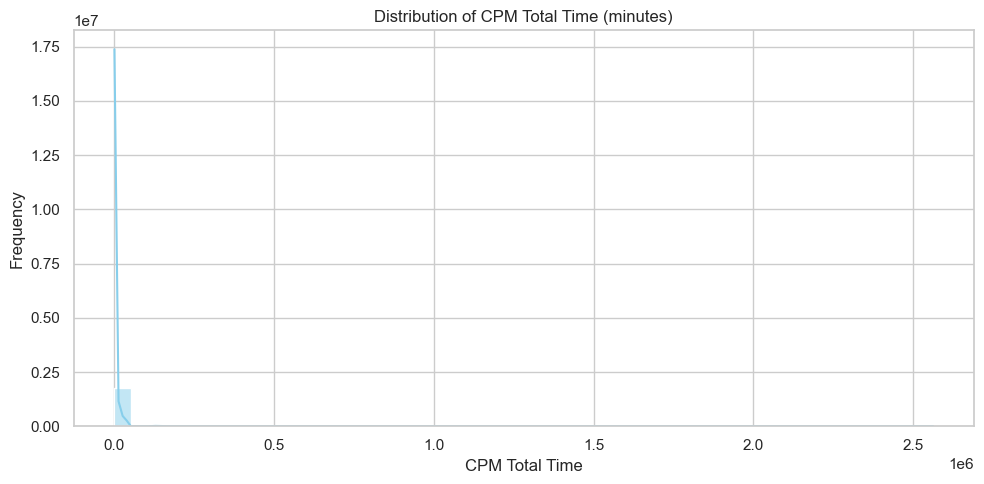

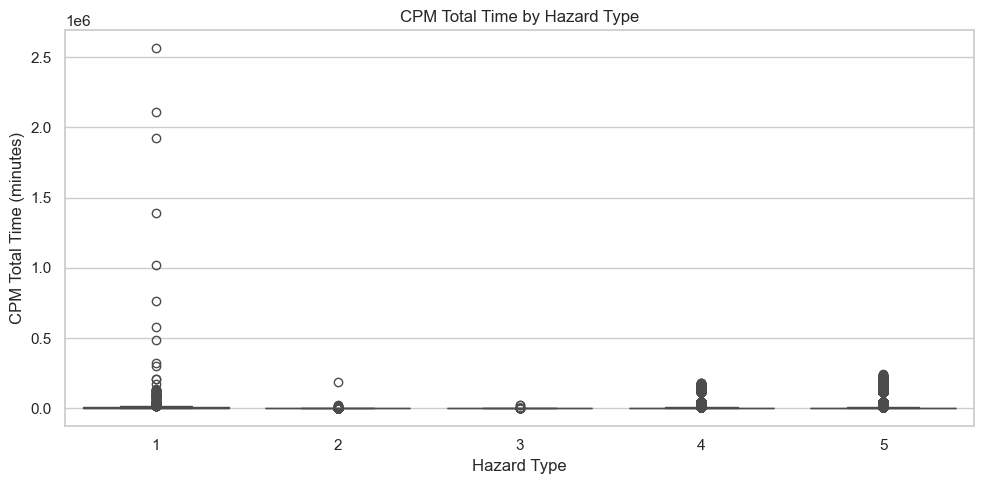

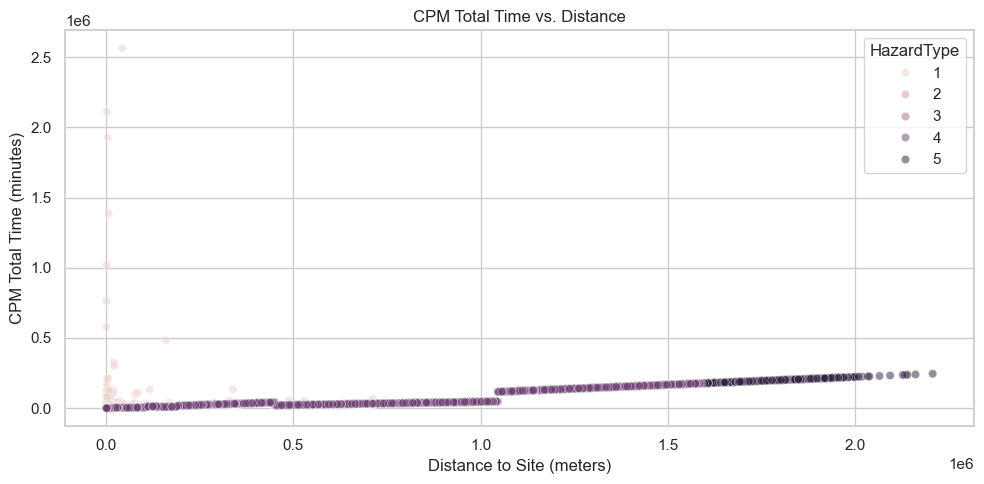

In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# Plot 1: Histogram of CPM Total Time
plt.figure(figsize=(10, 5))
sns.histplot(geohazard_df["cpm_total_time"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of CPM Total Time (minutes)")
plt.xlabel("CPM Total Time")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot 2: Boxplot by Hazard Type
plt.figure(figsize=(10, 5))
sns.boxplot(x="HazardType", y="cpm_total_time", data=geohazard_df)
plt.title("CPM Total Time by Hazard Type")
plt.xlabel("Hazard Type")
plt.ylabel("CPM Total Time (minutes)")
plt.tight_layout()
plt.show()

# Plot 3: Scatter (optional)
plt.figure(figsize=(10, 5))
sns.scatterplot(x="distance", y="cpm_total_time", hue="HazardType", data=geohazard_df, alpha=0.5)
plt.title("CPM Total Time vs. Distance")
plt.xlabel("Distance to Site (meters)")
plt.ylabel("CPM Total Time (minutes)")
plt.tight_layout()
plt.show()

# In case operation interrupted, START HERE!

In [ ]:
geohazard_df = pd.read_csv(r"D:\NDIS_Database\ghz_rf_cpm.csv") # In case operation interrupted
geohazard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 21 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   selected_sensor        object 
 10  sensor_id              int64  
 11  parameters             object 
 12  sensor_name            object 
 13  s_encoded              int64  
 14  sensor_weight          int64  
 15  selected_drone         object 
 16  drone_speed            float64
 17  drone_flight_time      float64
 18  travel_time            float64
 19  monitor_time           float64
 20  cpm_total_time         float64
dtypes: float64(12), int64(5), object(4)
memory usage: 290.

In [ ]:
# Count occurrences of "No suitable drone found"
no_suitable_drones_count = (geohazard_df["selected_drone"] == "No suitable drone found").sum()

# Display the count
print(f"Number of geohazards with no suitable drone: {no_suitable_drones_count}")

Number of geohazards with no suitable drone: 0


In [ ]:
geohazard_df.selected_drone.unique()

array(['IDEAFLY Poseidon-480 Pro II', 'IDEAFLY Thor-850', 'EAMS E484MP',
       'JTT Spider C85', 'Drone Volt Hercules 10', 'DJI Matrice100',
       'ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection',
       'DJI Matrice300RTK', 'Drone America Savant',
       'Aerialtronics Altura Zenith ATX8', 'ACSL AirTruck',
       'DJI Matrice200SeriesV2',
       'Dragandfly Innovations Inc Heavy Lift Drone',
       'Dragandfly Innovations Inc Starling X.2', 'DJI S900',
       'Acecore Zetona 8', 'Freespace Operation Callisto 50 Multirotor',
       'AeroSense Aerobo Wing (AS-VT01)', 'AEE Aviation Technology G10',
       'MMC Griflion M8', 'Doosan Mobility Dj25',
       'Garuda Robotics Cerana X8', 'Aerosonde Ltd AAI Aerosonde Mk 4.3',
       'Drone America Ariel', 'Drone America Phoebus', 'DJI AgrasT20',
       'Garuda Robotics Cerana ONE Pro'], dtype=object)

In [ ]:
geohazard_df

,HazardID,latitude,longitude,HazardType,distance,pop,intensity,duration_minutes,economic_loss_million,selected_sensor,...,parameters,sensor_name,s_encoded,sensor_weight,selected_drone,drone_speed,drone_flight_time,travel_time,monitor_time,cpm_total_time
0,210010,50.170000,6.850000,1,34.462092,1.346558e+05,2.0,1510.00,2.82,Seismic,...,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II,18.0,30.0,3.83,1510.00,1513.83
1,210020,45.775000,2.970000,1,1068.063073,4.145101e+05,3.0,9376.00,9.86,Seismic,...,velocity,Seismic,1,1000,IDEAFLY Thor-850,18.0,26.0,118.67,9376.00,9494.67
2,210030,42.170000,2.530000,1,1798.388196,1.461354e+05,1.0,33.00,0.51,Seismic,...,velocity,Seismic,1,1000,IDEAFLY Thor-850,18.0,26.0,199.82,33.00,232.82
3,210040,38.870000,-4.020000,1,547.012635,1.739199e+05,2.0,1672.00,2.62,Seismic,...,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II,18.0,30.0,60.78,1672.00,1732.78
4,211004,41.730000,12.700000,1,183.805721,2.411999e+06,1.0,151.00,0.99,Seismic,...,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II,18.0,30.0,20.42,151.00,171.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814694,1779999762,7.532258,-77.758715,4,55485.569192,7.768821e+03,1.0,90.05,0.01,Seismic,...,velocity,Seismic,1,1000,Drone America Savant,38.0,90.0,2920.29,90.05,3010.34
1814695,1779999849,6.942987,-77.639198,4,61702.289243,4.558220e+03,1.0,74.97,0.01,Seismic,...,velocity,Seismic,1,1000,Drone America Savant,38.0,90.0,3247.49,74.97,3322.46
1814696,1779999872,9.248675,-78.994425,4,1317.387302,5.720637e+04,1.0,70.05,0.02,Seismic,...,velocity,Seismic,1,1000,IDEAFLY Thor-850,18.0,26.0,146.38,70.05,216.43
1814697,1779999875,9.224729,-78.860133,4,692.425627,3.482288e+04,1.0,153.32,0.04,Seismic,...,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II,18.0,30.0,76.94,153.32,230.26


# Random Forest Process Starts Here

In [ ]:
geohazard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   selected_sensor        object 
 10  sensor_id              int64  
 11  parameters             object 
 12  sensor_name            object 
 13  s_encoded              int64  
 14  sensor_weight          int64  
 15  selected_drone         object 
 16  drone_speed            float64
 17  drone_flight_time      float64
 18  travel_time            float64
 19  monitor_time           float64
 20  cpm_total_time         float64
 21  drone_sensor_combo     object 
dtypes: float64(12), in

## RF Classification – Mission Recommendation

In [ ]:
geohazard_df["intensity"].fillna(1, inplace=True)  # or median (~3)
geohazard_df["duration_minutes"].fillna(30, inplace=True)
geohazard_df["economic_loss_million"].fillna(0, inplace=True)

In [ ]:
# ----------------------
# Step 1: Feature selection
# ----------------------
features = [
    "HazardType", "distance", "pop",
    "intensity", "duration_minutes",
    "economic_loss_million"
]

# ----------------------
# Step 2: Generate target label
# ----------------------
geohazard_df["drone_sensor_combo"] = (
    geohazard_df["selected_drone"].astype(str) + " + " + geohazard_df["selected_sensor"].astype(str)
)

# ----------------------
# Step 3: Drop NaNs and filter rare classes
# ----------------------
# Count label frequency
label_counts = geohazard_df["drone_sensor_combo"].value_counts()

# Keep only labels with at least 2 instances
# valid_labels = label_counts[label_counts >= 2].index

# Filter dataset
#rf_df = geohazard_df[
 #   geohazard_df["drone_sensor_combo"].isin(valid_labels)
#].dropna(subset=features + ["drone_sensor_combo"]).copy()
min_samples = 30  # or 50
valid_labels = geohazard_df["drone_sensor_combo"].value_counts()
valid_labels = valid_labels[valid_labels >= min_samples].index

rf_df = geohazard_df[geohazard_df["drone_sensor_combo"].isin(valid_labels)].copy()

# ----------------------
# Step 4: Encode target label
# ----------------------
label_encoder = LabelEncoder()
rf_df["label_encoded"] = label_encoder.fit_transform(rf_df["drone_sensor_combo"])

# ----------------------
# Step 5: Split into training and testing
# ----------------------
X = rf_df[features]
y = rf_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [ ]:
# ----------------------
# Step 1: Feature selection
# ----------------------
#features = [
#    "HazardType", "distance", "pop",
#    "intensity", "duration_minutes",
#    "economic_loss_million"
#]

# Save feature list
features = [
    "HazardType", "distance", "pop", "intensity",
    "duration_minutes", "economic_loss_million",
    "sensor_weight", "drone_speed", "drone_flight_time"
]
# ----------------------
# Step 2: Generate target label
# ----------------------
geohazard_df["drone_sensor_combo"] = (
    geohazard_df["selected_drone"].astype(str) + " + " + geohazard_df["selected_sensor"].astype(str)
)

# ----------------------
# Step 3: Drop NaNs and filter rare classes
# ----------------------
# Count label frequency
label_counts = geohazard_df["drone_sensor_combo"].value_counts()

# Keep only labels with at least 2 instances
# valid_labels = label_counts[label_counts >= 2].index

# Filter dataset
#rf_df = geohazard_df[
 #   geohazard_df["drone_sensor_combo"].isin(valid_labels)
#].dropna(subset=features + ["drone_sensor_combo"]).copy()
min_samples = 30  # or 50
valid_labels = geohazard_df["drone_sensor_combo"].value_counts()
valid_labels = valid_labels[valid_labels >= min_samples].index

rf_df = geohazard_df[geohazard_df["drone_sensor_combo"].isin(valid_labels)].copy()

# ----------------------
# Step 4: Encode target label
# ----------------------
label_encoder = LabelEncoder()
rf_df["label_encoded"] = label_encoder.fit_transform(rf_df["drone_sensor_combo"])

# ----------------------
# Step 5: Split into training and testing
# ----------------------
X = rf_df[features]
y = rf_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [ ]:
# Check how many NaNs per column
print(rf_df[features].isna().sum())

HazardType                   0
distance                     0
pop                          0
intensity                19424
duration_minutes         19424
economic_loss_million    19424
dtype: int64


In [ ]:
# ----------------------
# Step 6: Train Random Forest classifier
# ----------------------
start_time = timeit.default_timer()
#rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
#rf_model.fit(X_train, y_train)

# Uses Multiprocessing !BEWARE using all core might crash other running app and eventually TERMINATE this process
#n_cores = max(1, multiprocessing.cpu_count() // 2)

#rf_model = RandomForestClassifier(n_estimators=100, n_jobs=n_cores, max_depth=12,
#                                  class_weight="balanced", random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)

elapsed = timeit.default_timer() - start_time
print("\u2705 RF Training completed! Elapsed time: %s minutes" % str(elapsed / 60))

<class 'ValueError'>: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Save model
joblib.dump(rf_model, r"D:\NDIS_Database\rf_mission_model.joblib")

# Save label encoder
joblib.dump(label_encoder, r"D:\NDIS_Database\rf_label_encoder.joblib")

# Save feature list
feature_list = [
    "HazardType", "distance", "pop", "intensity",
    "duration_minutes", "economic_loss_million",
    "sensor_weight", "drone_speed", "drone_flight_time"
]
with open(r"D:\NDIS_Database\rf_features.json", "w") as f:
    json.dump(feature_list, f)

print("\u2705 All model assets saved.")

✅ All model assets saved.


In [ ]:
# Load saved model and label encoder
rf_model = joblib.load(r'D:\NDIS_Database\14_ExB_Dev\ndis2\rf_mission_model.joblib')         # Update with actual filename
label_encoder = joblib.load(r'D:\NDIS_Database\14_ExB_Dev\ndis2\rf_label_encoder.joblib')     # Update with actual filename

In [ ]:
# Option B: Two-step pipeline (Sensor → Drone)


# ---------------------------
# Setup
# ---------------------------
context_features = [
    "HazardType", "distance", "pop",
    "intensity", "duration_minutes", "economic_loss_million"
]

# ---------------------------
# Step 1: Predict Sensor
# ---------------------------
sensor_df = geohazard_df.dropna(subset=context_features + ["selected_sensor"]).copy()

# Encode sensor labels
sensor_encoder = LabelEncoder()
sensor_df["sensor_label"] = sensor_encoder.fit_transform(sensor_df["selected_sensor"])

X_sensor = sensor_df[context_features]
y_sensor = sensor_df["sensor_label"]

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_sensor, y_sensor, stratify=y_sensor, test_size=0.2, random_state=42
)

sensor_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
sensor_model.fit(X_train_s, y_train_s)

# Evaluate
print("Sensor Prediction Report:")
y_pred_s = sensor_model.predict(X_test_s)
print(classification_report(y_test_s, y_pred_s, target_names=sensor_encoder.classes_))

# ---------------------------
# Step 2: Predict Drone
# ---------------------------
drone_df = geohazard_df.dropna(subset=context_features + ["selected_sensor", "selected_drone"]).copy()

# Add encoded sensor as input feature
sensor_map = dict(zip(sensor_df["HazardID"], sensor_df["sensor_label"]))
drone_df["sensor_label"] = drone_df["HazardID"].map(sensor_map)

# Drop if sensor couldn't be mapped
drone_df = drone_df.dropna(subset=["sensor_label"]).copy()
drone_df["sensor_label"] = drone_df["sensor_label"].astype(int)

# Encode drone labels
drone_encoder = LabelEncoder()
drone_df["drone_label"] = drone_encoder.fit_transform(drone_df["selected_drone"])

X_drone = drone_df[context_features + ["sensor_label"]]
y_drone = drone_df["drone_label"]

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_drone, y_drone, stratify=y_drone, test_size=0.2, random_state=42
)

drone_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
drone_model.fit(X_train_d, y_train_d)

# Evaluate
print("\nDrone Prediction Report:")
y_pred_d = drone_model.predict(X_test_d)
print(classification_report(y_test_d, y_pred_d, target_names=drone_encoder.classes_))



KeyboardInterrupt



## RF Prediction and Evaluation

In [ ]:
# ----------------------
# Step 7: Predict and evaluate
# ----------------------
y_pred = rf_model.predict(X_test)

# Only include labels present in y_test
present_labels = sorted(set(y_test))

print("\nClassification Report:\n", classification_report(
    y_test, y_pred,
    labels=present_labels,
    target_names=label_encoder.inverse_transform(present_labels)
))


# ----------------------
# Step 8: Add predictions to full dataset
# ----------------------
rf_df["predicted_label"] = label_encoder.inverse_transform(rf_model.predict(X))


Classification Report:
                                                                   precision    recall  f1-score   support

                                         ACSL AirTruck + Seismic       0.90      1.00      0.95      4769
  ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection + Lidar       0.96      1.00      0.98        67
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection + Seismic       1.00      1.00      1.00     18344
                           AEE Aviation Technology G10 + Seismic       1.00      1.00      1.00     18907
                                      Acecore Zetona 8 + Seismic       1.00      0.99      0.99      3029
                        Aerialtronics Altura Zenith ATX8 + Lidar       1.00      1.00      1.00         7
                      Aerialtronics Altura Zenith ATX8 + Seismic       1.00      0.99      1.00      5369
                       AeroSense Aerobo Wing (AS-VT01) + Seismic       1.00      0.98      0.99      7541
                    

In [ ]:
# Try random guessing baseline (predict most frequent class)
most_common = rf_df["drone_sensor_combo"].mode()[0]
baseline_acc = (rf_df["drone_sensor_combo"] == most_common).mean()
print(f"Baseline (majority class) accuracy: {baseline_acc:.2f}")

Baseline (majority class) accuracy: 0.15


In [ ]:
print(rf_df.groupby("HazardType")["drone_sensor_combo"].nunique())

HazardType
1    25
2    12
3    13
4    26
5    26
Name: drone_sensor_combo, dtype: int64


In [ ]:
# Predict
y_pred = rf_model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Create heatmap (optional: limit to top 10)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
top_classes = pd.Series(y_test).value_counts().nlargest(10).index
top_class_labels = label_encoder.inverse_transform(top_classes)

cm_df_small = cm_df.loc[top_class_labels, top_class_labels]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df_small, annot=True, fmt='g', cmap='Blues', cbar=True, square=True)
plt.title('Confusion Matrix (Top 10 Drone+Sensor Labels)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

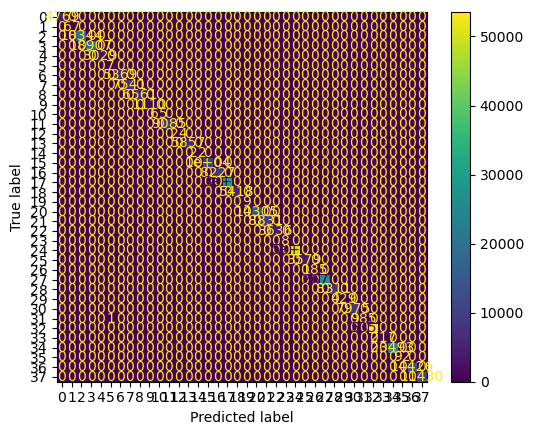

In [ ]:
confusion_matrix = ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [ ]:
y.value_counts()

label_encoded
32    267616
24    249865
17    150030
27    133986
34    117466
3      94532
2      91717
36     72130
20     71522
37     57152
15     51536
11     45424
21     44153
28     41556
16     41133
30     39874
7      37706
8      32806
13     29283
18     27091
6      26847
0      23847
22     18181
25     17893
4      15146
9       5551
31      4929
29      2143
33      1085
26       927
35       461
1        335
10       327
12       120
14       108
19        47
23        38
5         36
Name: count, dtype: int64

In [ ]:
# ----------------------
# Step 9: Export result to CSV
# ----------------------
rf_df[[
    "HazardID", "predicted_label", "drone_sensor_combo", *features, "cpm_total_time"
]].to_csv(r"D:\NDIS_Database\rf_mission_prediction.csv", index=False)

In [ ]:
# Save model
with open("rf_mission_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Save label encoder
with open("rf_label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Save feature list (still use JSON here, it's lightweight and human-readable)
feature_list = [
    "HazardType", "distance", "pop", "intensity",
    "duration_minutes", "economic_loss_million",
    "sensor_weight", "drone_speed", "drone_flight_time"
]
with open("rf_features.json", "w") as f:
    json.dump(feature_list, f)

print("✅ All model assets saved using pickle.")

In [ ]:
with open("rf_mission_model.pkl", "rb") as f:
    rf_model = pickle.load(f)

with open("rf_label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

with open("rf_features.json") as f:
    feature_list = json.load(f)

---

# Create a predict_mission() Function

In [ ]:
def predict_mission(input_dict):
    # Load assets
    model = joblib.load("rf_mission_model.joblib")
    encoder = joblib.load("rf_label_encoder.joblib")
    with open("rf_features.json") as f:
        features = json.load(f)

    # Convert input to DataFrame
    X_input = pd.DataFrame([input_dict])[features]

    # Predict class
    pred_class = model.predict(X_input)[0]
    pred_label = encoder.inverse_transform([pred_class])[0]

    return {
        "recommended_combo": pred_label
    }

In [ ]:
# Load saved model and label encoder
rf_model = joblib.load(r'D:\NDIS_Database\14_ExB_Dev\ndis2\rf_mission_model.joblib')         # Update with actual filename
label_encoder = joblib.load(r'D:\NDIS_Database\14_ExB_Dev\ndis2\rf_label_encoder.joblib')     # Update with actual filename

# Full dataset
df = geohazard_df

X = df.drop('drone_sensor_combo', axis=1)
y = label_encoder.transform(df['drone_sensor_combo'])  # encode using same encoder

# Optionally split to simulate testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Predict
y_pred = rf_model.predict(X_test)

# ----------------------
# Step 4: Encode target label
# ----------------------
label_encoder = LabelEncoder()
rf_df["label_encoded"] = label_encoder.fit_transform(df["drone_sensor_combo"])

# ----------------------
# Step 5: Split into training and testing
# ----------------------
X = rf_df[features]
y = rf_df["label_encoded"]

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Create heatmap (optional: limit to top 10)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
top_classes = pd.Series(y_test).value_counts().nlargest(10).index
top_class_labels = label_encoder.inverse_transform(top_classes)

cm_df_small = cm_df.loc[top_class_labels, top_class_labels]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df_small, annot=True, fmt='g', cmap='Blues', cbar=True, square=True)
plt.title('Confusion Matrix (Top 10 Drone+Sensor Labels)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

---

# For Display Purpose

In [ ]:
ghz_gpkg = r"D:\NDIS_Database\ghz84.gpkg"
# Load the GeoPackage
ghz = gpd.read_file(ghz_gpkg, layer="ghz84")
ghz

,HazardID,latitude,longitude,HazardType,geometry
0,2.100100e+05,50.170000,6.850000,1,POINT (6.85000 50.17000)
1,2.100200e+05,45.775000,2.970000,1,POINT (2.97000 45.77500)
2,2.100300e+05,42.170000,2.530000,1,POINT (2.53000 42.17000)
3,2.100400e+05,38.870000,-4.020000,1,POINT (-4.02000 38.87000)
4,2.110040e+05,41.730000,12.700000,1,POINT (12.70000 41.73000)
...,...,...,...,...,...
1933494,1.776288e+09,-14.438700,34.575740,4,POINT (34.57574 -14.43870)
1933495,1.771045e+09,-14.477742,34.599504,4,POINT (34.59950 -14.47774)
1933496,1.779958e+09,-14.516784,34.623267,4,POINT (34.62327 -14.51678)
1933497,1.778385e+09,-14.555826,34.647031,4,POINT (34.64703 -14.55583)


In [ ]:
ghz.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1933499 entries, 0 to 1933498
Data columns (total 5 columns):
 #   Column      Dtype   
---  ------      -----   
 0   HazardID    float64 
 1   latitude    float64 
 2   longitude   float64 
 3   HazardType  int64   
 4   geometry    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 73.8 MB


In [ ]:
geohazard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               int64  
 1   latitude               float64
 2   longitude              float64
 3   HazardType             int64  
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   selected_sensor        object 
 10  sensor_id              int64  
 11  parameters             object 
 12  sensor_name            object 
 13  s_encoded              int64  
 14  sensor_weight          int64  
 15  selected_drone         object 
 16  drone_speed            float64
 17  drone_flight_time      float64
 18  travel_time            float64
 19  monitor_time           float64
 20  cpm_total_time         float64
 21  coord                  object 
dtypes: float64(12), in

In [ ]:
# Step 1: Drop geometry from ghz if it's a GeoDataFrame
ghz_df = pd.DataFrame(ghz.drop(columns='geometry'))

# Round coordinates to avoid float mismatch
geohazard_df['latitude'] = geohazard_df['latitude'].round(6)
geohazard_df['longitude'] = geohazard_df['longitude'].round(6)
ghz_df['latitude'] = ghz_df['latitude'].round(6)
ghz_df['longitude'] = ghz_df['longitude'].round(6)

# Step 2: Create a coordinate tuple in both DataFrames
geohazard_df['coord'] = list(zip(geohazard_df['latitude'], geohazard_df['longitude'], geohazard_df['HazardType']))
ghz_df['coord'] = list(zip(ghz_df['latitude'], ghz_df['longitude'], ghz_df['HazardType']))

# Step 3: Filter only ghz rows with new coordinates
existing_coords = set(geohazard_df['coord'])
new_rows = ghz_df[~ghz_df['coord'].isin(existing_coords)]

# Step 4: Reindex to match columns in geohazard_df
new_rows_reindexed = new_rows.reindex(columns=geohazard_df.columns)

print(f"Total input (ghz): {len(ghz_df)}")
print(f"Subset (geohazard_df): {len(geohazard_df)}")
print(f"Filtered new rows: {len(new_rows)}")
print(f"Expected final count: {len(ghz_df)}")


# Step 5: Concatenate
combined_df = pd.concat([geohazard_df, new_rows_reindexed], ignore_index=True)

print(f"Actual final count: {len(combined_df)}")

# Map numeric HazardType to string labels
hazard_type_map = {
    1: 'Volcano',
    2: 'Landslide',
    3: 'Tsunami',
    4: 'Fault',
    5: 'Earthquake'
}

combined_df['HazardType'] = combined_df['HazardType'].map(hazard_type_map)

combined_df.info()

Total input (ghz): 1933499
Subset (geohazard_df): 1814699
Filtered new rows: 118548
Expected final count: 1933499
Actual final count: 1933247
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1933247 entries, 0 to 1933246
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   HazardID               float64
 1   latitude               float64
 2   longitude              float64
 3   HazardType             object 
 4   distance               float64
 5   pop                    float64
 6   intensity              float64
 7   duration_minutes       float64
 8   economic_loss_million  float64
 9   selected_sensor        object 
 10  sensor_id              float64
 11  parameters             object 
 12  sensor_name            object 
 13  s_encoded              float64
 14  sensor_weight          float64
 15  selected_drone         object 
 16  drone_speed            float64
 17  drone_flight_time      float64
 18  travel_time         

In [ ]:
# How many duplicate coordinate rows in ghz_df?
ghz_df['coord'] = list(zip(ghz_df['latitude'], ghz_df['longitude']))
dupe_coords = ghz_df.duplicated(subset='coord', keep=False)
print(f"Duplicate rows in ghz_df based on coordinates: {dupe_coords.sum()}")

Duplicate rows in ghz_df based on coordinates: 122570


In [ ]:
# Which geohazard_df coords are NOT in ghz_df?
missing_coords = set(geohazard_df['coord']) - set(ghz_df['coord'])
print(f"Coords in geohazard_df that are NOT in ghz_df: {len(missing_coords)}")

Coords in geohazard_df that are NOT in ghz_df: 0


In [ ]:
# Check for duplicated coordinates in ghz_df
ghz_df['coord'] = list(zip(ghz_df['latitude'], ghz_df['longitude']))
dupes = ghz_df.duplicated(subset='coord', keep=False)

print(f"Total duplicate coord rows in ghz_df: {dupes.sum()}")


Total duplicate coord rows in ghz_df: 122570


In [ ]:
# Drop duplicate coordinate rows before filtering
ghz_df_unique = ghz_df.drop_duplicates(subset='coord')
len(ghz_df_unique)

1855570

In [ ]:
# Step 6: Recreate geometry
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(combined_df['longitude'], combined_df['latitude'])]
combined_gdf = gpd.GeoDataFrame(combined_df.drop(columns='coord'), geometry=geometry, crs="EPSG:4326")

In [ ]:
combined_gdf.to_file(r"D:\NDIS_Database\13_NDIS_Display\final_geohazard.gpkg", layer="geohazards", driver="GPKG")